In [1]:
import tensorflow as tf
import numpy as np
import Dataset
from   ModelLoader import ModelLoader
from convnet import *
import datetime
import SimpleITK as sitk

import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
from myshow import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [ ]:
#Testing TF GPU Support

# Creates a graph.
a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
c = tf.matmul(a, b)
# Creates a session with log_device_placement set to True.
test_sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
# Runs the op.
print(test_sess.run(c))
test_sess.close()
    

In [29]:

model = ModelLoader('models/model_2.json')

data_manager = Dataset.DatasetManager(
    train=model.get_config('train_data_path'),
    test= model.get_config('test_data_path'),
    target_shape=model.get_config('data_shape')
)




after conv1[85 85 85]
after maxpool1[ 40.  40.  40.]
after conv2[ 40.  40.  40.]
after maxpool2[ 17.  17.  17.]
Loading dataset /home/mostafa/BigSpiroData/train/segmented_augmented_np/6/data_16.npy (sync) 
Loaded dataset /home/mostafa/BigSpiroData/train/segmented_augmented_np/6/data_16.npy of the shape (170, 614125)
Loading dataset /home/mostafa/BigSpiroData/train/segmented_augmented_np/6/data_22.npy (async) 


AttributeError: 'DatasetManager' object has no attribute 'get_current_ds'

Loaded dataset /home/mostafa/BigSpiroData/train/segmented_augmented_np/6/data_22.npy of the shape (170, 614125)


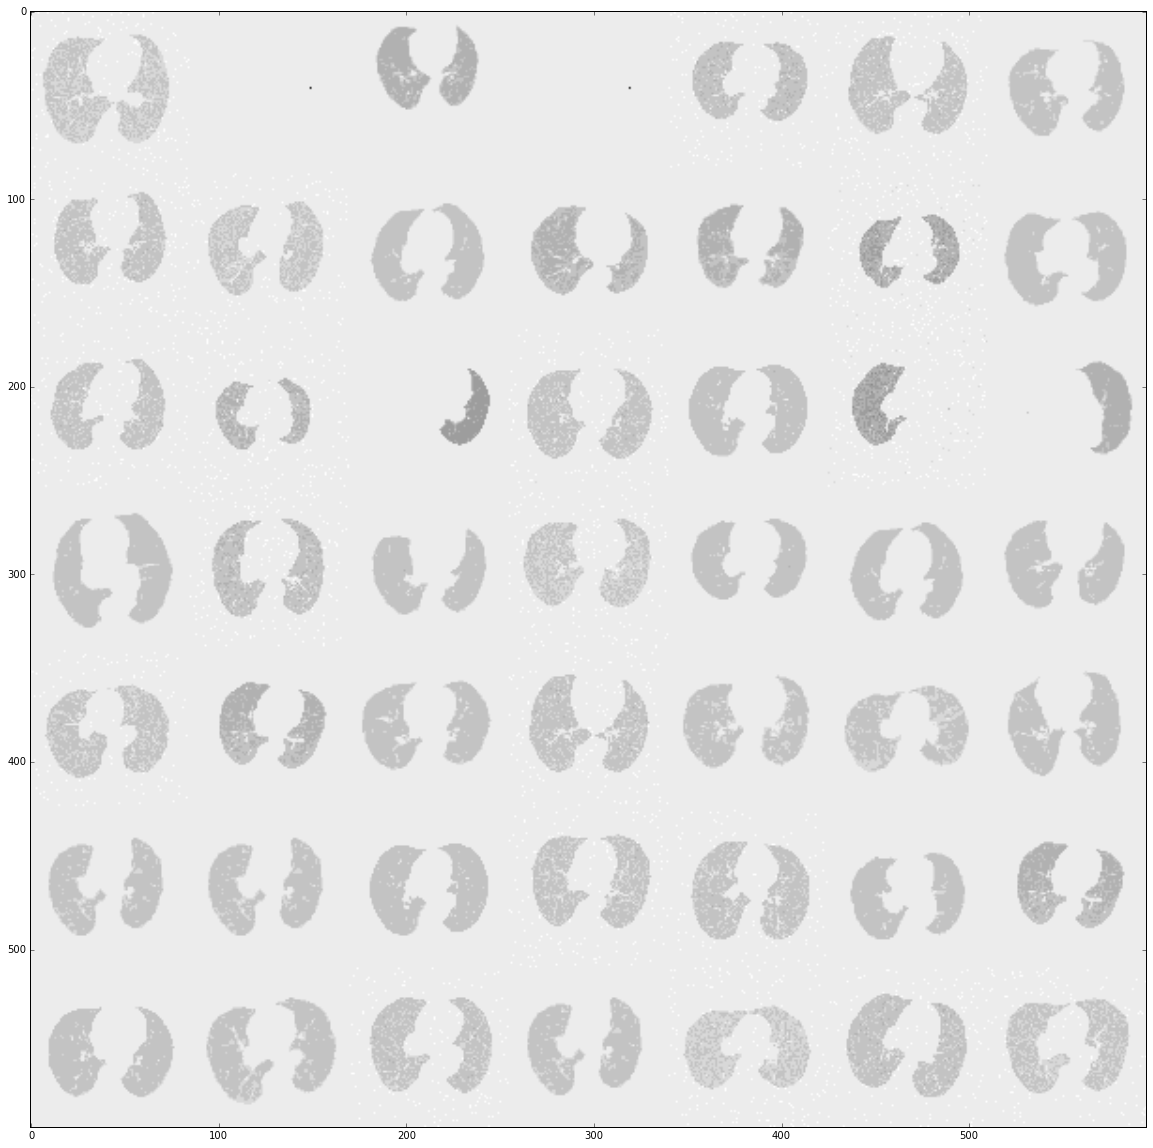

In [39]:
random_tile(data_manager.get_current_dataset(), (7, 7))

In [39]:
tf.reset_default_graph()

sess = tf.Session()

ds = data_manager.get_current_dataset()

# Network Parameters
data_shape = [ds.original_X_shape[1], ds.original_X_shape[2], ds.original_X_shape[3]]
n_input   = ds.original_X_shape[1] * ds.original_X_shape[2] * ds.original_X_shape[3]   # Input size
n_classes = model.get_config('n_classes')
dropout   = model.get_config('dropout')

# Parameters
learning_rate  = model.get_config('learning_rate')
training_iters = model.get_config('training_iters')
batch_size     = model.get_config('batch_size')
display_step   = model.get_config('display_step')

# tf Graph input
x = tf.placeholder(tf.float32, [None, n_input])
y = tf.placeholder(tf.float32, [None, n_classes])


with tf.name_scope('dropout'):
    keep_prob = tf.placeholder(tf.float32) #dropout (keep probability)
    tf.scalar_summary('dropout_keep_probability', keep_prob)
    
# Construct model
pred = conv_net(x, data_shape, model.get_weights(), model.get_biases(), keep_prob)

# Define loss and optimizer
with tf.name_scope('cross_entropy'):
    with tf.name_scope('total'):
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(pred, y))
        tf.scalar_summary('cost', cost)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Evaluate model
correct_pred = tf.equal(tf.argmax(pred, 1), tf.argmax(y, 1))
with tf.name_scope('accuracy'):
    accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
    tf.scalar_summary('accuracy', accuracy)

# Initializing the variables
merged = tf.merge_all_summaries()

str_now = datetime.datetime.now().strftime("%d-%m-%Y#%H_%M_%S")

train_writer = tf.train.SummaryWriter('logs/train/' + '/' + model.get_config('id') +  str_now, sess.graph)
test_writer  = tf.train.SummaryWriter('logs/test/'  + '/' + model.get_config('id') +  str_now, sess.graph)

init = tf.initialize_all_variables()
sess.run(init)

# Load test dataset
test_dataset = data_manager.get_test_dataset()


[85, 85, 85]
Input to Conv1 (?, 85, 85, 85, 1)
Output of Conv1 (?, 85, 85, 85, 32)
Input to MaxPool1 (?, 85, 85, 85, 32)
Output of MaxPool1 (?, 40, 40, 40, 32)
Input to Conv2 (?, 40, 40, 40, 32)
Output of Conv2 (?, 40, 40, 40, 32)
Input to MaxPool2 (?, 40, 40, 40, 32)
Output to MaxPool2 (?, 17, 17, 17, 32)
Loading dataset /home/mostafa/BigSpiroData/test/raw_np/6/data_0.npy (sync) 
Loaded dataset /home/mostafa/BigSpiroData/test/raw_np/6/data_0.npy of the shape (12, 614125)


In [33]:
x = 8 * 25 * (64 * 64 * 64 * 1 ) + (5 * 5 * 5 * 1 * 12 ) + (5 * 5 * 5 * 12 * 12) + (8 * 8 * 8 * 12 * 256) + (256 * 2)

x / (1024 * 1024  * 1024)


0.050311606377363205

In [48]:
# Launch the graph
step = 1

with sess:
    
    test_batch_x, test_batch_y = test_dataset.next_batch(4)
    test_dict = {
        x: test_batch_x,
        y: test_batch_y,
        keep_prob: 1.0
    }

    
    # Keep training until reach max iterations
    while step * batch_size < training_iters:

        batch_x, batch_y = data_manager.next_batch(batch_size)
        train_dict = {
            x: batch_x, 
            y: batch_y, 
            keep_prob: 1.0
        }
                        
        # Run optimization op (backprop)
        summary, _ = sess.run([merged, optimizer], feed_dict=train_dict)
        train_writer.add_summary(summary, step)

        if step % display_step == 0:
            # Calculate batch loss and accuracy
            train_acc, train_loss = sess.run([accuracy, cost], feed_dict=train_dict)
            summary, test_acc  = sess.run([merged, accuracy], feed_dict=test_dict)

            test_writer.add_summary(summary, step)
            
            print( "Iter " + str(step * batch_size) + 
                ", Minibatch Loss = {:.6f}".format(train_loss) + 
                ", Training Accuracy = {:.5f}".format(train_acc) + 
                ", Test Accuracy = {:.5f}".format(test_acc)
             )

        step += 1
        
    saver = tf.train.Saver()
    save_path = saver.save(sess, "/tmp/model.ckpt")
    print("Model saved in file: %s" % save_path)

    print("Optimization Finished!")

train_writer.close()
test_writer.close()


Iter 30, Minibatch Loss = 596521.187500, Training Accuracy = 1.00000, Test Accuracy = 1.00000
Iter 60, Minibatch Loss = 179687.343750, Training Accuracy = 0.33333, Test Accuracy = 1.00000
Iter 90, Minibatch Loss = 838276.000000, Training Accuracy = 0.00000, Test Accuracy = 0.00000
Iter 120, Minibatch Loss = 781900.000000, Training Accuracy = 1.00000, Test Accuracy = 1.00000


KeyboardInterrupt: 

In [ ]:
# Load test dataset
test_dataset = data_manager.get_test_dataset()

In [ ]:
# Get a batch of training examples
test_batch_x, test_batch_y = test_dataset.next_batch(5)

# Run test
print("Testing Accuracy:", sess.run(accuracy, feed_dict={x: test_batch_x, y: test_batch_y, keep_prob: 1.}))

In [ ]:
sess.close()

